In [86]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Blur image, Threshold

In [87]:
def mean_threshold(img, display=True):
    mean = np.mean(img)

    img[img >= mean] = 255
    img[img < mean] = 0

    if display:
        plt.figure(figsize = [10, 10])
        plt.axis('off')
        plt.imshow(img, cmap="gray")

    return img

In [88]:
def threshold(img, threshold=0.5):
    img[img >= threshold] = 1
    img[img < threshold] = 0

    return img
    

In [89]:
def clean_img(img_path):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for _ in range(5):
        img = cv2.blur(img, (10, 10))
        mean_threshold(img)

    return img 

In [90]:
# img = clean_img('../dataset/handwritten_operators/plus/plus 2.png')
# plt.axis('off')
# plt.imshow(img, cmap='gray')

In [91]:
def adaptive_clean(img_path, load=True, mode='otsu'):
    # Load image
    if load:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    else:
        img = img_path

    # Convert to grayscale and apply Otsu's binarization for noise reduction
    # https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    img = cv2.GaussianBlur(img,(5,5),0)
    if mode == 'otsu':
        _, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # or you can use gaussian/mean adaptive thresholding
    elif mode == 'mean':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    elif mode == 'gaussian':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    img = 255 - img

    # Can also apply some morphological transformations
    # https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((3, 3), dtype=np.uint8) # or you can use cv2.getStructuringElement()
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img


(135, 155)


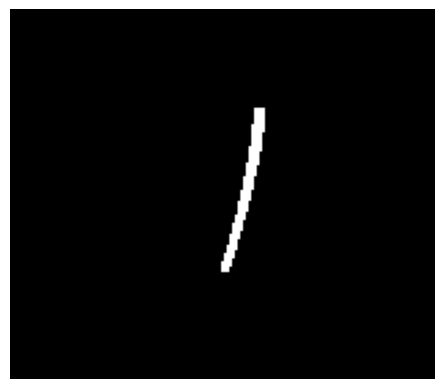

In [92]:
img = adaptive_clean('../dataset/1/dataset1_1_12.jpg')
print(img.shape)
plt.axis('off')
plt.imshow(img, cmap='gray')

# Center the Image

In [93]:
# img = cv2.imread('./Four_full (16).jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# h, w = img.shape[:2]
# new = np.zeros((h, w, 3), dtype=np.uint8)
# new[:, :, :] = img[:, :, :]

# plt.axis('off')
# plt.imshow(new)

In [94]:
from math import ceil
# Center and square an image
def center_img(img):
    # Assuming the image is clean, choose the bounding box for the symbol
    bx, by, bw, bh = cv2.boundingRect(img)
    print(bx, by, bw, bh)

    dim = max(bw, bh) * 1.05 # width of canvas 
    x_tl, y_tl = dim / 1.05 / 2 - bw / 2 + dim / 1.05 * .025, dim / 1.05 / 2 - bh / 2 + dim / 1.05 * .025 # top left corner

    dim = ceil(dim)
    x_tl, y_tl = int(x_tl), int(y_tl)
    centered = np.zeros((dim, dim))

    for y in range(by, by + bh):
        for x in range(bx, bx + bw):
            centered[y - by + y_tl][x - bx + x_tl] = img[y][x]
            
    return centered

77 36 16 60


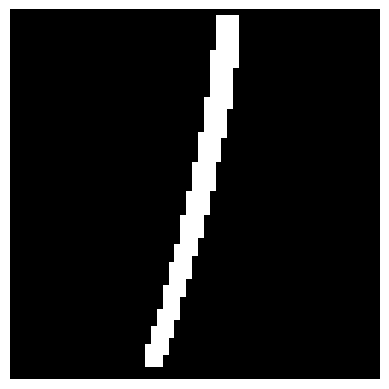

In [95]:
centered = center_img(img)
plt.axis('off')
plt.imshow(centered, cmap='gray')

# Rescale the Image

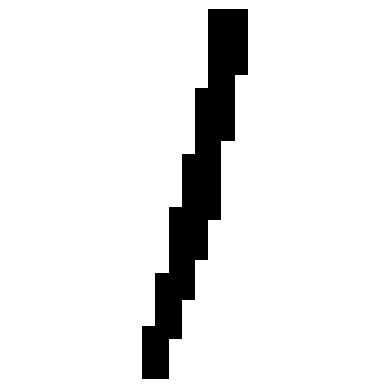

In [96]:
# need similar padding for all images
# same center, scale, thickness

def resize_img(img, dim=28):

    resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_AREA)
    # resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_CUBIC)

    resize[resize > 0] = 100
    resize[resize < 100] = 255
    resize[resize == 100] = 0

    return resize

resized = resize_img(centered)
plt.axis('off')
plt.imshow(resized, cmap='gray')

# Removing shadows, hist-eq

In [104]:
def remove_shadows(img):
    # Generate the shadow of the image
    # Create a 9x9 kernel, can also use np.ones()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # Some morphology operators
    # https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html 
    # https://docs.opencv.org/3.4/d3/dbe/tutorial_opening_closing_hats.html
    shadow = cv2.dilate(img, kernel) # Make the background bleed into the text to cover it up

    # Filtering
    # https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html
    shadow = cv2.medianBlur(shadow, 21) # Use a median filter to cover up the text entirely (there may still be particles in the text), now we have an image with only the shadow

    res = 255 - cv2.absdiff(img, shadow) # Remove the shadow from the original image
    return res

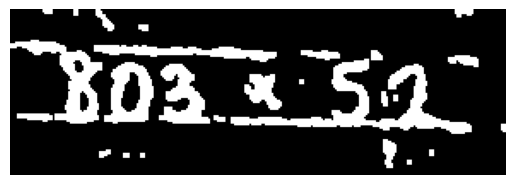

In [106]:
# from cv2 import dnn_superres
img = cv2.imread('../equation-dataset/dark-background/6.png', cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = remove_shadows(img)
# upsampling may improve results
# https://docs.opencv.org/4.x/d5/d29/tutorial_dnn_superres_upscale_image_single.html
# sr = dnn_superres.DnnSuperResImpl_create()
# sr.readModel("./FSRCNN_x2.pb")
# sr.setModel("fsrcnn", 2)
# img = sr.upsample(img)
# CLAHE
# https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
clahe = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(14,7))
img = clahe.apply(img)
# Clean
img = adaptive_clean(img, load=False)

plt.axis('off')
plt.imshow(img, cmap='gray')

# All together

In [98]:
def standardize(img_path):
    img = adaptive_clean(img_path)
    img = center_img(img)
    img = resize_img(img)
    return img

In [99]:
import os
print(os.listdir('../test_data_01'))

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']


In [100]:
print(np.max(img))

255


138 105 166 196
151 90 129 248
122 78 141 213
75 75 132 130
140 100 104 207


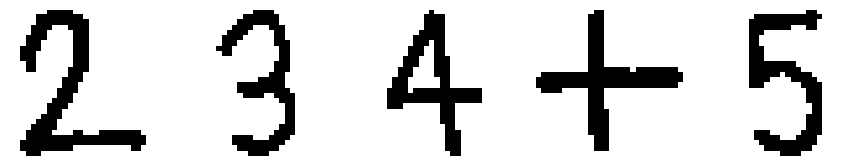

In [102]:
fig = plt.figure(figsize=(20, 10))
i = 0
for image in os.listdir('../test_data_01/')[1:]:
    resized = standardize(os.path.join('../test_data_01/', image))
    ax = fig.add_subplot(1, 9, i+1)
    i+=1
    ax.axis('off')
    plt.imshow(resized, cmap='gray')
    plt.imsave("s " + image, resized, cmap='gray')
plt.show()